In [70]:
import numpy as np
import pandas as pd
import os
import string
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import metrics
import cv2
from sklearn.model_selection import GridSearchCV

In [145]:
# dataset = pd.read_csv("leaves_dataset_aug.csv")
dataset = pd.read_csv("leaves.csv")
dataset.head(5)

X = dataset.iloc[:,2:]

y = dataset['species']
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 135)
X_train.head(5)


#skaliranje
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [ ]:
!pip install mahotas

     |████████████████████████████████| 5.7MB 4.8MB/s 


In [72]:
import mahotas as mt
import re
import matplotlib
import matplotlib.pyplot as plt

In [146]:
parameters = [{'kernel': ['rbf'],
               'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5],
               'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
             ]
svm_clf = GridSearchCV(svm.SVC(decision_function_shape='ovr'), parameters)
svm_clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [133]:
svm_clf.best_params_

{'C': 100, 'kernel': 'linear'}

In [134]:
clf = svm.SVC(C=100.0, decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',)
clf.fit(X_train,y_train)

SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# filename = 'finalized_model2.sav'
# pickle.dump(clf, open(filename, 'wb'))
# pickle.dump(sc_X, open('standard_scaler2.sav', 'wb'))

In [135]:
y_pred = clf.predict(X_test)

metrics.accuracy_score(y_test, y_pred)

0.9092495636998255

In [140]:
def preprocess_leaf(image):
  names = ['area','perimeter','pysiological_length','pysiological_width','aspect_ratio','rectangularity','circularity', \
        'mean_r','mean_g','mean_b','stddev_r','stddev_g','stddev_b', \
        'contrast','correlation','inverse_difference_moments','entropy'
      ]
  df = pd.DataFrame([], columns=names)
  gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
  plt.imshow(gray,cmap='Greys_r')
  plt.show()

  blur = cv2.GaussianBlur(gray, (55,55),0)
  plt.imshow(blur,cmap='Greys_r')
  plt.show()

  ret,otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  plt.imshow(otsu,cmap='Greys_r')
  plt.show()

  kernel = np.ones((50,50),np.uint8) 
  plt.imshow(kernel,cmap='Greys_r')
  plt.show()

  closing = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, kernel) #mask

  contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  len(contours)

  cnt = contours[0]
  len(cnt)

  area = cv2.contourArea(cnt)
  perimeter = cv2.arcLength(cnt,True)

#Shape features
  x,y,w,h = cv2.boundingRect(cnt)
  aspect_ratio = float(w)/h
  rectangularity = (w*h/area)
  circularity = ((perimeter)**2)/area
  print(rectangularity)


#Color features
  red_channel = img[:,:,0]
  green_channel = img[:,:,1]
  blue_channel = img[:,:,2]
  blue_channel[blue_channel == 255] = 0
  green_channel[green_channel == 255] = 0
  red_channel[red_channel == 255] = 0

  red_mean = np.mean(red_channel)
  green_mean = np.mean(green_channel)
  blue_mean = np.mean(blue_channel)

  red_std = np.std(red_channel) 
  green_std = np.std(green_channel)
  blue_std = np.std(blue_channel)

#Texture features
  textures = mt.features.haralick(gray)
  ht_mean = textures.mean(axis=0)
  contrast = ht_mean[1]
  correlation = ht_mean[2]
  inverse_diff_moments = ht_mean[4]
  entropy = ht_mean[8]

  vector = [area,perimeter,w,h,aspect_ratio,rectangularity,circularity,\
      red_mean,green_mean,blue_mean,red_std,green_std,blue_std,\
      contrast,correlation,inverse_diff_moments,entropy]
  df_temp = pd.DataFrame([vector],columns=names)
  df = df.append(df_temp)
  return df

In [159]:
train_df = pd.read_csv('maple_coord.csv')
print(train_df)

   Unnamed: 0       name    x    y     w    h
0           0  maple.jpg  564   32   815  261
1           0  maple.jpg  475  228   677  416
2           0  maple.jpg  832  332  1023  565
3           0  maple.jpg  320   68   542  319
4           0  maple.jpg  763  687   948  878


In [160]:
classes = []
def find_class(leaf_features):
  scaled_features = sc_X.transform(leaf_features)
  print(scaled_features)
#  print(scaled_features)
# y_pred_mobile = svm_clf.predict(features_of_img)
  y_pred_mobile = clf.predict(scaled_features)
  classes.append(y_pred_mobile[0])

In [161]:
def find_outpt(classes):
   return max(set(classes), key = classes.count)

def calculate_percent(classes, class_index):
  result = classes.count(class_index)*100.0/len(classes)
  return result

def get_name(class_index):
  common_names = ['pubescent bamboo','Chinese horse chestnut','Anhui Barberry', \
                'Chinese redbud','true indigo','Japanese maple','Nanmu',' castor aralia', \
                'Chinese cinnamon','goldenrain tree','Big-fruited Holly','Japanese cheesewood', \
                'wintersweet','camphortree','Japan Arrowwood','sweet osmanthus','deodar','ginkgo, maidenhair tree', \
                'Crape myrtle, Crepe myrtle','oleander','yew plum pine','Japanese Flowering Cherry','Glossy Privet',\
                'Chinese Toon','peach','Ford Woodlotus','trident maple','Beales barberry','southern magnolia',\
                'Canadian poplar','Chinese tulip tree','tangerine'
               ]
  return common_names[class_index]

In [162]:
def find_contour(cnts, resized_image):
    contains = []
    y_ri,x_ri, _ = resized_image.shape
    for cc in cnts:
        yn = cv2.pointPolygonTest(cc,(x_ri//2,y_ri//2),False)
        contains.append(yn)

    val = [contains.index(temp) for temp in contains if temp>0]
    print(contains)
    return val[0]

In [163]:
def background_remover(img):
  ## convert to hsv
  print("here")
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  plt.imshow(hsv)
  plt.show()
  ## mask of green (36,0,0) ~ (70, 255,255)
  mask_green = cv2.inRange(hsv, (20, 52, 72), (90, 255,255))
  # find the brown color
  mask_brown = cv2.inRange(hsv, (8, 60, 20), (30, 255, 200))
  ## mask o yellow (15,0,0) ~ (36, 255, 255)
  mask_yellow = cv2.inRange(hsv, (15,0,0), (36, 255, 255))

  ## final mask and masked
  lower = np.array([100, 42, 69])
  upper = np.array([179, 255, 255])
  mask = cv2.inRange(hsv, lower, upper) 
  mask = cv2.bitwise_or(mask_yellow, mask_brown)
  mask = cv2.bitwise_or(mask_green, mask_brown)
  # mask = cv2.bitwise_or(mask_green, mask_yellow)
  target = cv2.bitwise_and(img,img, mask=mask)
  
  plt.imshow(target)
  plt.show()
  print("moze")
  return target

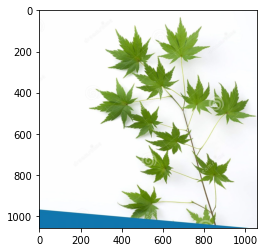

(1057, 1057, 3)
564 32 251 229
here


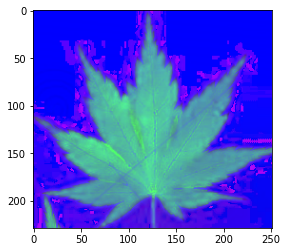

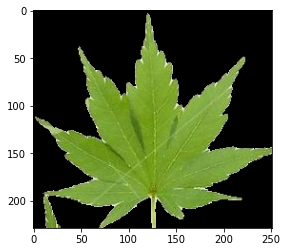

moze


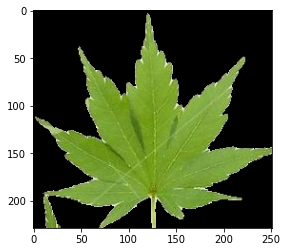

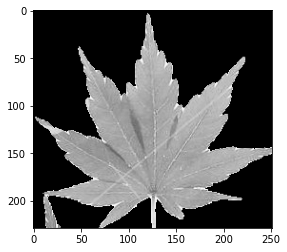

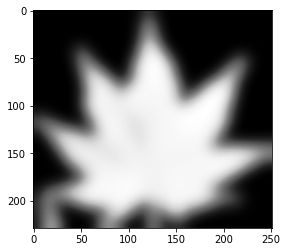

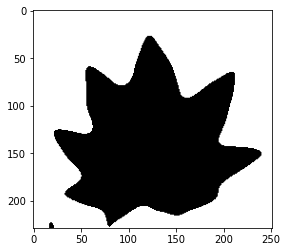

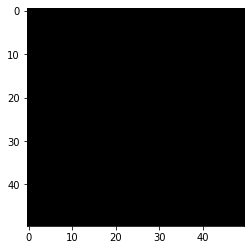

1.0084035087719299
      area  perimeter  ... inverse_difference_moments   entropy
0  57000.0      956.0  ...                   0.651457  5.594651

[1 rows x 17 columns]
[[ -2.20809582  -4.79476143  -6.43966674  -3.27891524  -0.86864384
   -0.46344497  -0.44270266   2.1110313    2.12707957   3.36063416
    4.30306343   2.1143986    3.65353631  26.4238407  -33.46079829
   -0.89777809   0.67282185]]
475 228 202 188
here


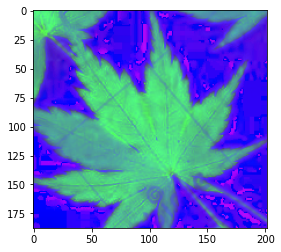

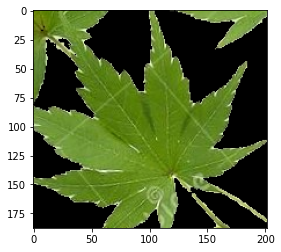

moze


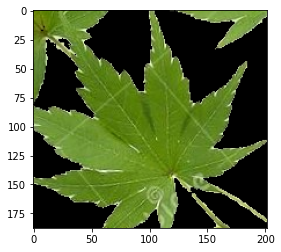

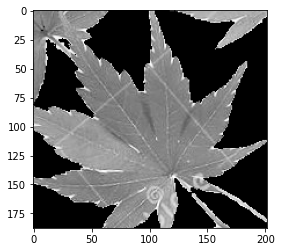

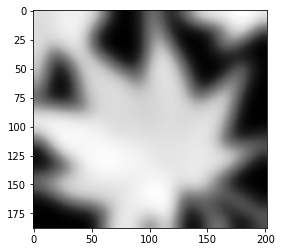

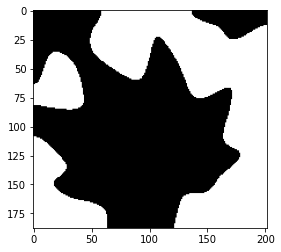

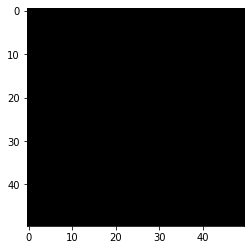

1.7892529859360644
      area    perimeter  ... inverse_difference_moments   entropy
0  21224.5  1150.610171  ...                   0.502647  7.731871

[1 rows x 17 columns]
[[ -2.34960789  -4.46359488  -6.733733    -3.48083402  -0.90677975
   -0.26678847   0.77628097   2.1110313    2.12707957   3.36063416
    4.30306343   2.1143986    3.65353631  41.16099284 -64.88542156
   -2.36186787   1.97833727]]
832 332 191 233
here


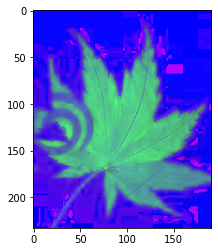

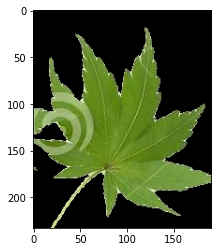

moze


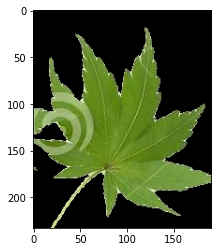

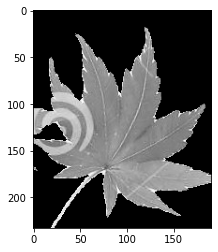

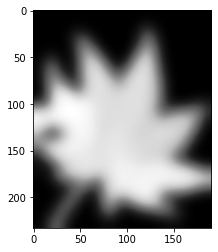

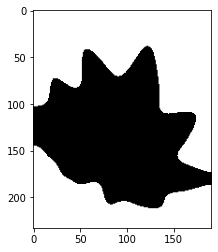

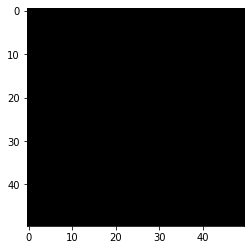

1.0095961887477314
      area  perimeter  ... inverse_difference_moments   entropy
0  44080.0      844.0  ...                   0.638489  6.017658

[1 rows x 17 columns]
[[ -2.25920163  -4.98535093  -6.79974787  -3.25921585  -1.35647371
   -0.46314459  -0.43938553   2.1110313    2.12707957   3.36063416
    4.30306343   2.1143986    3.65353631  28.97271127 -43.98829697
   -1.02536845   0.93121482]]
320 68 222 251
here


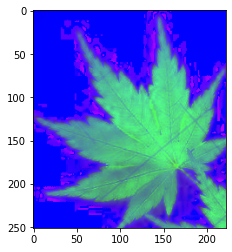

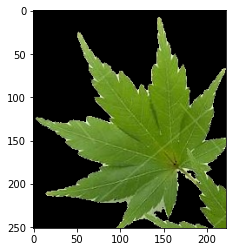

moze


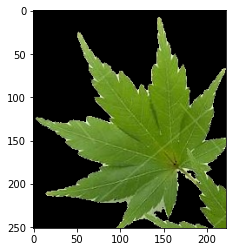

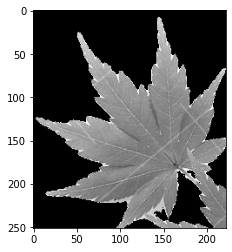

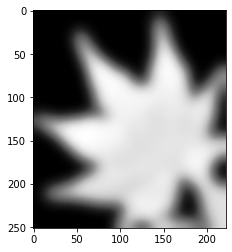

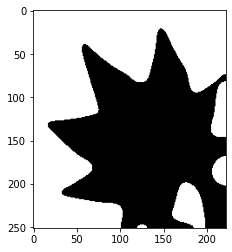

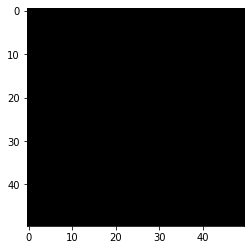

1.0085429864253395
      area  perimeter  ... inverse_difference_moments   entropy
0  55250.0      942.0  ...                   0.605878  6.389507

[1 rows x 17 columns]
[[ -2.21501805  -4.81858512  -6.61370595  -3.17056858  -1.24221726
   -0.46340984  -0.44199451   2.1110313    2.12707957   3.36063416
    4.30306343   2.1143986    3.65353631  27.80390297 -45.4410402
   -1.3462146    1.1583579 ]]
763 687 185 191
here


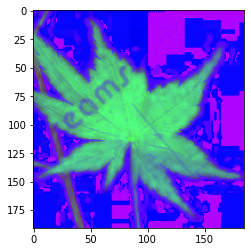

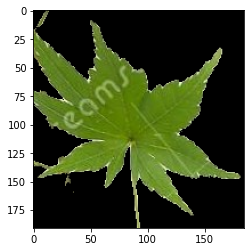

moze


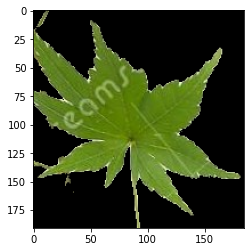

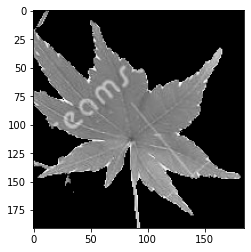

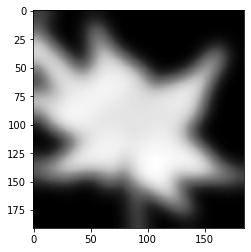

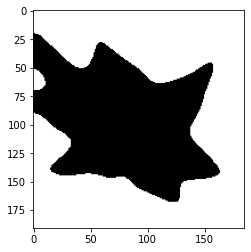

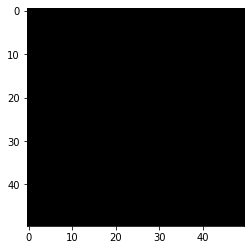

1.0107265446224256
      area  perimeter  ... inverse_difference_moments   entropy
0  34960.0      748.0  ...                   0.654157  5.539808

[1 rows x 17 columns]
[[ -2.29527632  -5.14871335  -6.83575598  -3.46605947  -1.09370388
   -0.46285991  -0.44348772   2.1110313    2.12707957   3.36063416
    4.30306343   2.1143986    3.65353631  29.19085276 -52.87818927
   -0.87121961   0.63932099]]
Found classes:  [5, 5, 5, 5, 5]
This plant is  100.0  percent  Japanese maple


In [164]:
#Identifying plant
# detektovani listovi sa upisanim koordinatama
img = cv2.imread("maple.jpg")
classes = []
original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # konvertovanje iz BGR u RGB model boja (OpenCV ucita sliku kao BGR)
plt.imshow(original_img)
plt.show()
print(original_img.shape)
for index, row in train_df.iterrows():
  x = int(row['x'])
  y = int(row['y'])
  w = int(row['w'])-x
  h = int(row['h'])-y
  print(x,y,w,h)
  # crop_img = original_img.crop((x,y, w,h))
  crop_img = original_img[y:y + h,x:x + w]
  # isThrowable = w/h* 1.0 < 0.3
  # if(isThrowable): print("nece moci")
  crop_img = background_remover(crop_img)
  
  plt.imshow(crop_img)
  plt.show()
   
  leaf_features = preprocess_leaf(crop_img)
  print(leaf_features)
  find_class(leaf_features)
print("Found classes: ", classes)
leaf_class = find_outpt(classes)
result = calculate_percent(classes, leaf_class)
print("This plant is ", result, " percent ", get_name(leaf_class))
# plt.imshow(crop_img)
# print(row['x'], row['y'], row['w'], row['h'])

In [ ]:
#prepoznavanje lista kada na slici ima jedan list
img = cv2.imread("1.jpg")
original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # konvertovanje iz BGR u RGB model boja (OpenCV ucita sliku kao BGR)
classes = []

leaf_features = preprocess_leaf(original_img)
print(leaf_features)

X_test = sc_X.transform(leaf_features)
y_pred = clf.predict(X_test)
print(y_pred)

      area    perimeter pysiological_length pysiological_width  aspect_ratio  \
0  51214.0  1332.925967                 617                120      5.141667   

   rectangularity  circularity      mean_r      mean_g      mean_b   stddev_r  \
0        1.445698    34.691523  223.491163  239.857546  236.316202  74.835073   

    stddev_g   stddev_b   contrast  correlation  inverse_difference_moments  \
0  32.954426  41.047277  21.045037     0.992468                     0.87381   

    entropy  
0  4.235698  
[2]
